In [ ]:
import torch
import numpy as np
from networks import BayesianNetwork, MLP
from config import RLConfig
from utils import read_data_rl
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Bandit():
    def __init__(self, label, bandit_params, x, y):
        self.n_samples = bandit_params['n_samples']
        self.buffer_size = bandit_params['buffer_size']
        self.batch_size = bandit_params['batch_size']
        self.num_batches = bandit_params['num_batches']
        self.lr = bandit_params['lr']
        self.epsilon = bandit_params['epsilon']
        self.cumulative_regrets = [0]
        self.buffer_x, self.buffer_y = [], []
        self.x, self.y = x, y
        self.label = label
        self.init_net(bandit_params)

    def get_agent_reward(self, eaten, edible):
        if not eaten:
            return 0
        if eaten and edible:
            return 5
        elif eaten and not edible:
            return 5 if np.random.rand() > 0.5 else -35

    def get_oracle_reward(self, edible):
        return 5*edible 

    def take_action(self, mushroom):
        context, edible = self.x[mushroom], self.y[mushroom]
        eat_tuple = torch.FloatTensor(np.concatenate((context, [1, 0]))).unsqueeze(0).to(device)
        reject_tuple = torch.FloatTensor(np.concatenate((context, [0, 1]))).unsqueeze(0).to(device)

        # evaluate reward for actions
        with torch.no_grad():
            self.net.eval()
            reward_eat = sum([self.net(eat_tuple) for _ in range(self.n_samples)]).item()
            reward_reject = sum([self.net(reject_tuple) for _ in range(self.n_samples)]).item()

        eat = reward_eat > reward_reject
        # epsilon-greedy agent
        if np.random.rand() < self.epsilon:
            eat = (np.random.rand() < 0.5)
        agent_reward = self.get_agent_reward(eat, edible)


        # record context, action, reward
        action = torch.Tensor([1, 0] if eat else [0, 1])
        self.buffer_x.append(np.concatenate((context, action)))
        self.buffer_y.append(agent_reward)

        # calculate regret
        regret = self.get_oracle_reward(edible) - agent_reward
        self.cumulative_regrets.append(self.cumulative_regrets[-1]+regret)

    def update(self, mushroom):
        self.take_action(mushroom)
        l = len(self.buffer_x)

        if l <= self.batch_size:
            idx_pool = int(self.batch_size//l + 1)*list(range(l))
            idx_pool = np.random.permutation(idx_pool[-self.batch_size:])
        elif l > self.batch_size and l < self.buffer_size:
            idx_pool = int(l//self.batch_size)*self.batch_size
            idx_pool = np.random.permutation(list(range(l))[-idx_pool:])
        else:
            idx_pool = np.random.permutation(list(range(l))[-self.buffer_size:])

        context_pool = torch.Tensor([self.buffer_x[i] for i in idx_pool]).to(device)
        value_pool = torch.Tensor([self.buffer_y[i] for i in idx_pool]).to(device)
        
        for i in range(0, len(idx_pool), self.batch_size):
            self.loss_info = self.loss_step(context_pool[i:i+self.batch_size], value_pool[i:i+self.batch_size], i//self.batch_size)


In [ ]:
class BNN_Bandit(Bandit):
    def __init__(self, label, *args):
        super().__init__(label, *args)

    
    def init_net(self, parameters):
        model_params = {
            'input_shape': self.x.shape[1]+2,
            'classes': 1 if len(self.y.shape)==1 else self.y.shape[1],
            'batch_size': self.batch_size,
            'hidden_units': parameters['hidden_units'],
            'experiment': parameters['experiment'],
            'mu_init': parameters['mu_init'],
            'rho_init': parameters['rho_init'],
            'prior_init': parameters['prior_init']
        }
        self.net = BayesianNetwork(model_params).to(device)
        self.optimiser = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=5000, gamma=0.5)
        print(f'Bandit {self.label} Parameters: ')
        print(f'buffer_size: {self.buffer_size}, batch size: {self.batch_size}, number of samples: {self.n_samples}, epsilon: {self.epsilon}')
        print("BNN Parameters: ")
        print(f'input shape: {model_params["input_shape"]}, hidden units: {model_params["hidden_units"]}, output shape: {model_params["classes"]}, lr: {self.lr}')

    def loss_step(self, x, y, batch_id):
        beta = 2 ** (self.num_batches - (batch_id + 1)) / (2 ** self.num_batches - 1) 
        self.net.train()
        self.net.zero_grad()
        loss_info = self.net.sample_elbo(x, y, beta, self.n_samples)
        net_loss = loss_info[0]
        net_loss.backward()
        self.optimiser.step()
        return loss_info


class Greedy_Bandit(Bandit):
    def __init__(self, label, *args):
        super().__init__(label, *args)
    
    def init_net(self, parameters):
        model_params = {
            'input_shape': self.x.shape[1]+2,
            'classes': 1 if len(self.y.shape)==1 else self.y.shape[1],
            'batch_size': self.batch_size,
            'hidden_units': parameters['hidden_units'],
            'experiment': parameters['experiment']
        }
        self.net = MLP(model_params).to(device)
        self.optimiser = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimiser, step_size=5000, gamma=0.5)
        print(f'Bandit {self.label} Parameters: ')
        print(f'buffer_size: {self.buffer_size}, batch size: {self.batch_size}, number of samples: {self.n_samples}, epsilon: {self.epsilon}')
        print("MLP Parameters: ")
        print(f'input shape: {model_params["input_shape"]}, hidden units: {model_params["hidden_units"]}, output shape: {model_params["classes"]}, lr: {self.lr}')

    def loss_step(self, x, y, batch_id):
        self.net.train()
        self.net.zero_grad()
        net_loss = torch.nn.functional.mse_loss(self.net(x).squeeze(), y, reduction='sum')
        net_loss.backward()
        self.optimiser.step()
        return net_loss

BNN Parameters: 
x shape: 119, hidden units: 100, output shape: 1, lr: 0.0001
Bandit greedy_bandit Parameters: 
buffer_size: 4096, batch size: 64, number of samples: 1, epsilon: 0
MLP Parameters: 
x shape: 119, hidden units: 100, output shape: 1, lr: 0.0001
Bandit greedy_bandit_001 Parameters: 
buffer_size: 4096, batch size: 64, number of samples: 1, epsilon: 0.01
MLP Parameters: 
x shape: 119, hidden units: 100, output shape: 1, lr: 0.0001
Bandit greedy_bandit_005 Parameters: 
buffer_size: 4096, batch size: 64, number of samples: 1, epsilon: 0.05
MLP Parameters: 
x shape: 119, hidden units: 100, output shape: 1, lr: 0.0001
Initialising training on cuda...


/tmp/ipykernel_331391/2502984858.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  context_pool = torch.Tensor([self.buffer_x[i] for i in idx_pool]).to(device)


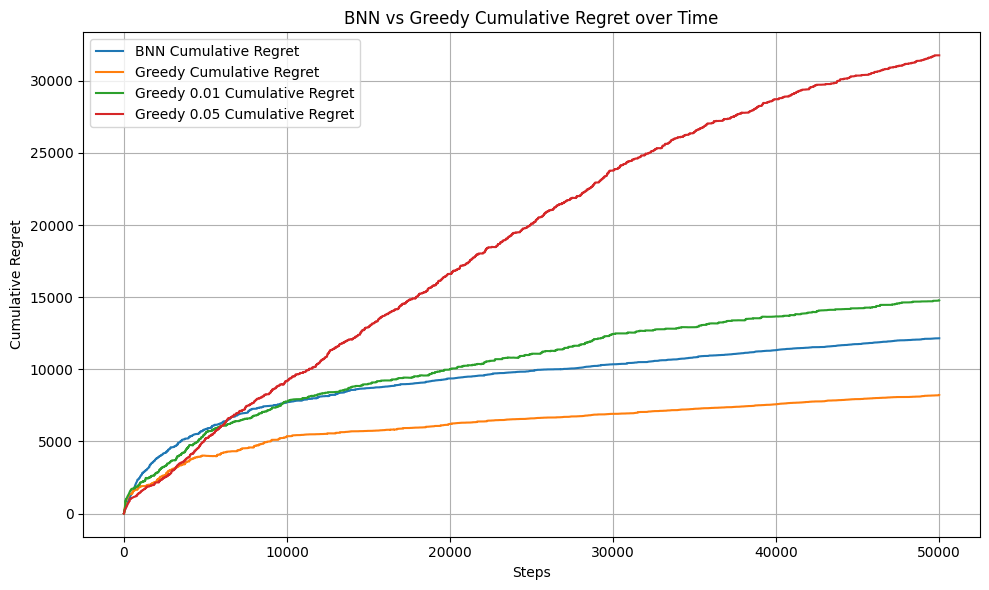

In [ ]:
def rl_trainer():
    config = RLConfig
    X, Y = read_data_rl(config.data_dir)

    params = {
        'buffer_size': config.buffer_size,
        'batch_size': config.batch_size,
        'num_batches': config.num_batches,
        'lr': config.lr,
        'hidden_units': config.hidden_units,
        'experiment': config.experiment,
        'mu_init': config.mu_init,
        'rho_init': config.rho_init,
        'prior_init': config.prior_init
    }

    bnn_bandit = BNN_Bandit('bnn_bandit', {**params, 'n_samples':2, 'epsilon':0}, X, Y)
    greedy_bandit = Greedy_Bandit('greedy_bandit', {**params, 'n_samples':1, 'epsilon':0}, X, Y)
    greedy_bandit_001 = Greedy_Bandit('greedy_bandit_001', {**params, 'n_samples':1, 'epsilon':0.01}, X, Y)
    greedy_bandit_005 = Greedy_Bandit('greedy_bandit_005', {**params, 'n_samples':1, 'epsilon':0.05}, X, Y)
    
    
    training_steps = config.training_steps
    print(f"Initialising training on {device}...")
    training_data_len = len(X)
    for step in tqdm(range(training_steps), disable=True): 
        mushroom = np.random.randint(training_data_len)
        bnn_bandit.update(mushroom)
        greedy_bandit.update(mushroom)
        greedy_bandit_001.update(mushroom)
        greedy_bandit_005.update(mushroom)
        
        bnn_bandit.scheduler.step()
        greedy_bandit.scheduler.step()
        greedy_bandit_001.scheduler.step()
        greedy_bandit_005.scheduler.step()

    # Plot cumulative regret
    plt.figure(figsize=(10, 6))
    plt.plot(bnn_bandit.cumulative_regrets, label='BNN Cumulative Regret')
    plt.plot(greedy_bandit.cumulative_regrets, label='Greedy Cumulative Regret')
    plt.plot(greedy_bandit_001.cumulative_regrets, label='Greedy 0.01 Cumulative Regret')
    plt.plot(greedy_bandit_005.cumulative_regrets, label='Greedy 0.05 Cumulative Regret')
    plt.xlabel('Steps')
    plt.ylabel('Cumulative Regret')
    plt.title('BNN vs Greedy Cumulative Regret over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


rl_trainer()